In [3]:
import os
import re

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import Audio
from librosa.feature.inverse import mel_to_audio
from scipy.io import wavfile
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.NSynthDataset import NSynthDataset
from src.SpecGAN import SpecGANGenerator
from src.utils import estimate_pitch

In [4]:
batch_size = 50
z_size = 1000

# min len =16000
sr = 8191
duration = 2
hop_length, n_fft = 128, 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
os.chdir('../../..')
path = 'mnt/data/public/NSynth/'

In [6]:
train_set = NSynthDataset(data_path=path,
                          mel=True,  pitched_z=False, 
                          sampling_rate=sr, duration=duration, 
                          min_class_count=10000, max_class_count=3000,
                          z_size=z_size)

In [7]:
test_set = NSynthDataset(data_path=path,
                          stage='test',
                          mel=True,  pitched_z=False, 
                          sampling_rate=sr, duration=duration, 
                          cond_classes=train_set.cond_classes,
                          return_pitch=True,
                          z_size=z_size)

In [8]:
gen = SpecGANGenerator(z_size, train_set.label_size, train_set.y_size).to(device)

gen.load_state_dict(torch.load(f'users/adcy353/GANs-Conditional-Audio-Synthesis/models/spec2/G_0.0001-1-827.pt'))
gen.eval()

SpecGANGenerator(
  (fc): Linear(in_features=1006, out_features=16384, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (9): Tanh()
  )
)

In [9]:
def display_spec(specs):
    fig, axs = plt.subplots(1, len(specs), figsize=(10, 3))
    for i in range(len(specs)):
        librosa.display.specshow(np.array(specs[i]),  y_axis='mel', x_axis='time', ax=axs[i], cmap='magma')
        axs[i].set_title('Mel Spectrogram')
    plt.show()    



bass_synthetic 49 C♯


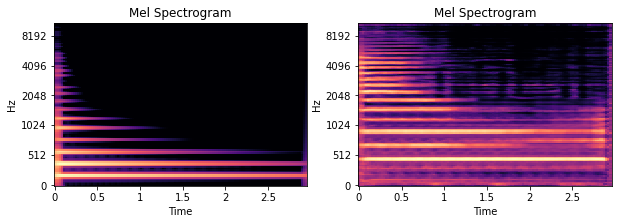

64.23407070666975 E

organ_electronic 63 D♯


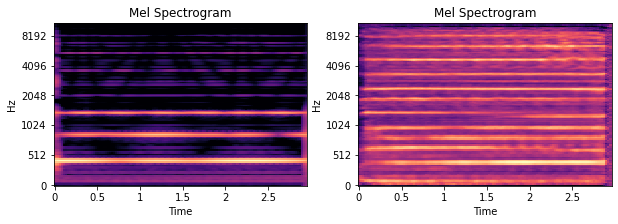

69.49191376057648 A

string_acoustic 46 A♯


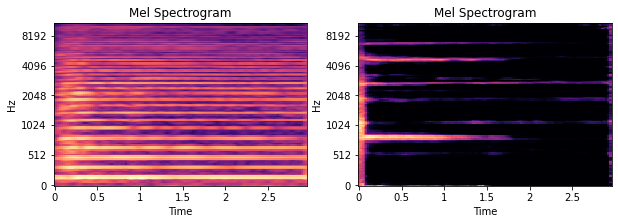

78.27757126898028 F♯

bass_synthetic 79 G


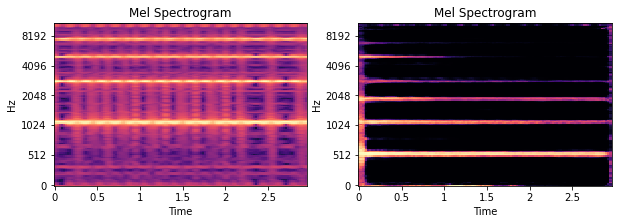

67.04266462346271 G

organ_electronic 67 G


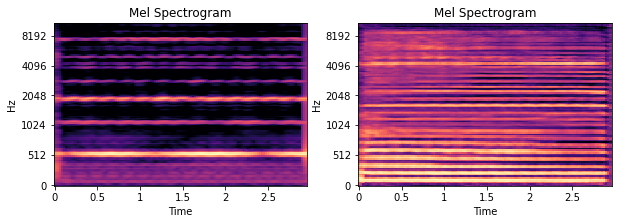

67.01079762906738 G

bass_synthetic 76 E


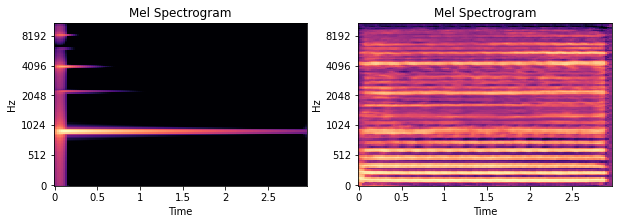

68.06701800481929 G♯

bass_synthetic 78 F♯


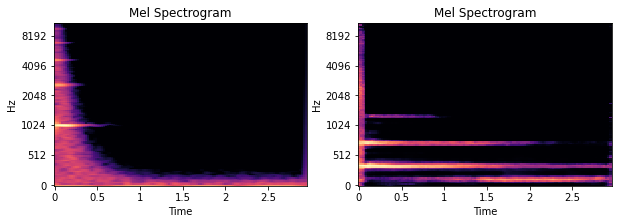

60.1712142612503 C

keyboard_electronic 69 A


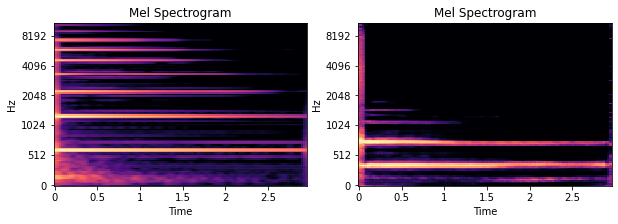

60.1712142612503 C

organ_electronic 69 A


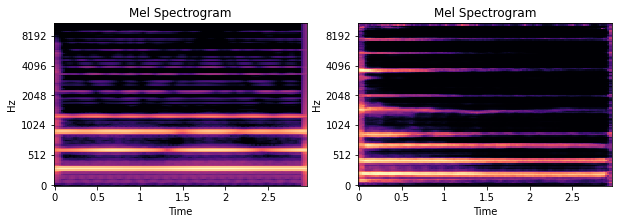

63.141508303893794 D♯


In [10]:
s_i = []
for i in range(0, 900, 100):
    w, l, z, pitch = test_set.__getitem__(i)
    inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
    
    print(f'\n{inst} {pitch.item()} {librosa.midi_to_note(pitch, octave=False).item()}')
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()

    display_spec((w, s))
    
    w_audio = mel_to_audio(np.array(w), sr=train_set.sampling_rate, n_fft=n_fft, hop_length=hop_length)
    s_audio = mel_to_audio(np.array(s), sr=train_set.sampling_rate, n_fft=n_fft, hop_length=hop_length)

    display(Audio(w_audio, rate=train_set.sampling_rate))
    display(Audio(s_audio, rate=train_set.sampling_rate))

    pitch, f0 = estimate_pitch(s_audio, sr)
    print(pitch, librosa.midi_to_note(pitch, octave=False)) 

## Outputs sample

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(7, 4, figsize=(30, 45))
for a, i in enumerate(range(0, 1200, 86)):
    w, l, z, pitch = test_set.__getitem__(i)
    inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
    
    label = f'{inst} {pitch.item()}'
    orig_label = f'({a+1}) Original (inv) - {label}'
    gen_label = f'({a+1}) Generated - {label}'
    
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()
    
    librosa.display.specshow(np.array(w), y_axis='mel', x_axis='time', ax=ax.flatten()[2*a], cmap='magma')
    librosa.display.specshow(np.array(s), y_axis='mel', x_axis='time', ax=ax.flatten()[2*a+1], cmap='magma')
    ax.flatten()[2*a].set_title(orig_label, fontdict={'fontsize':'large', 'weight':'bold'})
    ax.flatten()[2*a+1].set_title(gen_label, fontdict={'fontsize':'large', 'weight':'bold'})
    fig.tight_layout() 
    
    w_audio = mel_to_audio(np.array(w), sr=sr, n_fft=1024, hop_length=128)
    s_audio = mel_to_audio(np.array(s), sr=sr, n_fft=1024, hop_length=128)
    
    folder = 'users/adcy353/GANs-Conditional-Audio-Synthesis/results/spec/'
    wavfile.write(f'{folder}{orig_label}.wav', sr, np.array(w_audio).astype(np.float32))
    wavfile.write(f'{folder}{gen_label}.wav', sr, np.array(s_audio).astype(np.float32))


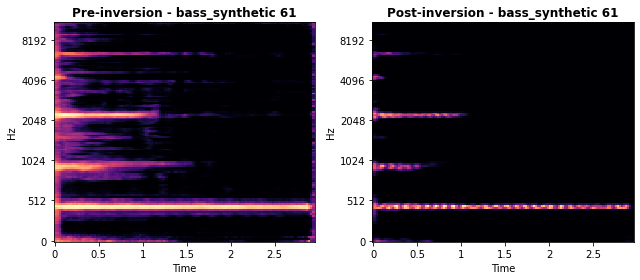

In [24]:
i = 104
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

w, l, z, pitch = test_set.__getitem__(i)
inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
label = f'{inst} {pitch.item()}'
pre_label = f'Pre-inversion - {label}'
post_label = f'Post-inversion - {label}'

s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
s.to(torch.device('cpu'))
s = s.detach().cpu()

s_audio = mel_to_audio(np.array(s), sr=sr, n_fft=1024, hop_length=128)
s_mel = librosa.feature.melspectrogram(y=np.array(s_audio), sr=sr, n_fft=1024, hop_length=128, n_mels=128)

librosa.display.specshow(np.array(s), y_axis='mel', x_axis='time', ax=ax[0], cmap='magma')
librosa.display.specshow(np.array(s_mel), y_axis='mel', x_axis='time', ax=ax[1], cmap='magma')

ax[0].set_title(pre_label, fontdict={'fontsize':'large', 'weight':'bold'})
ax[1].set_title(post_label, fontdict={'fontsize':'large', 'weight':'bold'})

fig.tight_layout() 



In [ ]:
b_size = 50
testloader = DataLoader(test_set, b_size, shuffle=False, drop_last=True)

In [ ]:
pitches_diff = []
est_pitch = []
real_pitch = []
for data in tqdm(testloader, leave=True):
    # forward pass
    x, l, z, p = data
    gen.eval()
    s = gen(z.to(device), l.to(device))
    #s[126:] = s.min()
    
    # audio reconstruction
    s_audio = []
    for i in range(b_size):
        audio = mel_to_audio(np.array(s[i].detach().cpu()), sr=sr, n_fft=n_fft, hop_length=hop_length)
        s_audio.append(audio)

        
    # pitch diff and accuracy
    p_est = torch.tensor([estimate_pitch(row, sr)[0] for row in s_audio]).unsqueeze(1)
    est_pitch.append(p_est)
    pitch_diff = abs(p_est - p)
    pitches_diff.append(pitch_diff)
    real_pitch.append(p)

## Pitch diff

In [ ]:
diffs = torch.cat(pitches_diff, dim=0)
diffs.mean().item(), diffs.median().item()

In [ ]:
x = range(int(diffs.max()) + 1)
y = [(diffs < thresh).sum().round() for thresh in x]
plt.bar(x, y)

In [ ]:
colors = list(range(len(x)))
for i in range(len(x)):
    if x[i] % 12 == 0:
        colors[i] = 'purple'
    elif x[i] % 5 == 0:
        colors[i] = 'm'
    else:
        colors[i] = 'plum'

y2 = [(diffs.round() == t).sum() for t in x]
plt.bar(x, y2, color=colors)
plt.legend()

In [ ]:
y2 = [(diffs.round() == t).sum().item() for t in x]
colors = [0 for _ in x]
for t in range(len(colors)):
    if t % 12 == 0:
        colors[t] = '12 semitone error'
    elif t % 7 == 0:
        colors[t] = '7 semitone error'
    else:
        colors[t] = 'Other semitone error'

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[1].bar(x, y, color='plum')
ax[1].set_title('Pitch error (cumulative)')
ax[1].set_xlabel('n° of semitones')
ax[1].set_ylabel('count')
ax[1].set_xlim(-2, 56)

df = pd.DataFrame((zip(x, y2, colors)), columns=['x', 'y', 'hue'])
sns.barplot(df, x='x', y='y', hue='hue', ax=ax[0], palette=['purple', 'm', 'plum'], dodge=False, hue_order=['12 semitone error', '7 semitone error', 'Other semitone error'])
ax[0].set_title('Pitch error')
ax[0].set_xlabel('n° of semitones')
ax[0].set_ylabel('Count')
ax[0].set_xticks(list(range(0, 56, 10)))
ax[0].set_xlim(-2, 56)
ax[0].legend(loc='upper right')


## Pitch accuracy

In [ ]:
estimated_pitch = torch.cat(est_pitch).round()
real_pitch = torch.cat(real_pitch)

In [ ]:
(estimated_pitch == real_pitch).sum() / estimated_pitch.shape[0]

## Note accuracy

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

estimated_notes = np.array([librosa.midi_to_note(pitch, octave=False).item() for pitch in estimated_pitch])
real_notes = np.array([librosa.midi_to_note(pitch, octave=False).item() for pitch in real_pitch])
acc = accuracy_score(real_notes, estimated_notes)
labels = sorted(np.unique(real_notes))
cm = confusion_matrix(real_notes, estimated_notes, labels=labels, normalize='true')
print(f'Accuracy = {acc}')
sns.heatmap(cm, square=True, xticklabels=labels, yticklabels=labels, vmax=1)